In [1]:
import json
from tqdm import tqdm

In [2]:
# Loading the json file 
file = 'News_Category_Dataset_v3.json'

data = []
with open(file, 'r') as f:
    for line in f:
        data.append(json.loads(line.strip()))

print(len(data))       # Number of articles
print(data[0])         # First article

209527
{'link': 'https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9', 'headline': 'Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters', 'category': 'U.S. NEWS', 'short_description': 'Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.', 'authors': 'Carla K. Johnson, AP', 'date': '2022-09-23'}


In [3]:
# Lists to hold the articles and categories separately
articles = []
categories = []
description=[]
# Iterate over each item in the data and separate 'headline' and 'category'
for item in data:
    articles.append(item['headline'])    # You can use other fields as well, such as 'short_description'
    categories.append(item['category'])
    description.append(item['short_description'])
print("Done")

Done


In [4]:
print(articles[43])
print(description[43])
print(categories[43])

'The Phantom Of The Opera' To Close On Broadway Next Year
“The Phantom of the Opera” — Broadway’s longest-running show — is scheduled to close in February 2023, a victim of post-pandemic softening in theater attendance in New York.
ENTERTAINMENT


In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize stop words, lemmatizer, and stemmer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize, remove stop words, and apply lemmatization and stemming
    cleaned_words = []
    for word in text.split():
        if word not in stop_words:
            # Lemmatize and then stem each word
            lemmatized_word = lemmatizer.lemmatize(word)
            stemmed_word = stemmer.stem(lemmatized_word)
            cleaned_words.append(stemmed_word)
    return ' '.join(cleaned_words)

# Apply the updated cleaning function to articles and descriptions
cleaned_articles = [clean_text(article) for article in articles]
cleaned_description = [clean_text(desc) for desc in description]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VICTUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\VICTUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\VICTUS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
cleaned_articles[10]

'world cup captain want wear rainbow armband qatar'

In [7]:
# calculate the unique word count in the cleaned articles list

unique_words = set()
for article in cleaned_description:
    unique_words.update(article.split())
print(len(unique_words))

64851


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Define tokenizer and fit on the cleaned articles
vocab_size = 100000  # Set a limit on the number of words in the vocabulary
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

# Fit the tokenizer on both cleaned articles and descriptions
tokenizer.fit_on_texts(cleaned_articles + cleaned_description)

# Convert articles to sequences of integers
article_sequences = tokenizer.texts_to_sequences(cleaned_articles)
description_sequences = tokenizer.texts_to_sequences(cleaned_description)

In [9]:
#get the max length of the article in article_sequences
max_article_length = max(len(seq) for seq in article_sequences)
print(max_article_length)

36


In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Pad sequences to a fixed length for consistency
max_length = 36
padded_article_sequences = pad_sequences(article_sequences, maxlen=max_length, padding='post', truncating='post')

In [11]:
# analysing the catogories
len(categories)

209527

In [12]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(categories)  # Assuming categories is a list of the corresponding categories for each article

In [13]:
from tensorflow.keras.utils import to_categorical
labels_one_hot = to_categorical(labels)
labels_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
from sklearn.model_selection import train_test_split

# Split the padded sequences and one-hot encoded labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    padded_article_sequences,  # Your padded sequences
    labels_one_hot,           # Your one-hot encoded labels
    test_size=0.2,            # 20% of the data for testing
    random_state=42            # Seed for reproducibility
)

# Optional: Print the shapes of the resulting datasets
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')


X_train shape: (167621, 36), y_train shape: (167621, 42)
X_test shape: (41906, 36), y_test shape: (41906, 42)


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout

# Define the model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),  # Embedding layer
    GlobalAveragePooling1D(),  # Reduces the output to a fixed size
    Dense(128, activation='relu'),  # Hidden layer
    Dropout(0.5),  # Dropout for regularization
    Dense(y_train.shape[1], activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(
    optimizer='adam',  # Adam optimizer
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy']  # Metric to evaluate the model's performance
)

# Build the model (this can also be done by fitting the model)
model.build(input_shape=(None, max_length))  # Input shape is (batch_size, max_length)

# Now, you can view the model summary
model.summary()

c:\Users\VICTUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 36, 128)        │    12,800,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 42)             │         5,418 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,821,930 (48.91 MB)

 Trainable params: 12,821,930 (48.91 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Define EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

model_checkpoint = ModelCheckpoint(
    'TxtClassification.keras',  # Filepath to save the model
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the model if the validation loss improves
    mode='min',  # Save when the monitored quantity is minimized
    verbose=1  # Verbosity mode
)

In [17]:
# Fit the model to the training data with callbacks
history = model.fit(
    X_train, 
    y_train, 
    epochs=20, 
    batch_size=32,  
    validation_data=(X_test, y_test),  
    callbacks=[model_checkpoint],  # Add callbacks here
    verbose=2  
)


Epoch 1/20

Epoch 1: val_loss improved from inf to 2.00419, saving model to TxtClassification.keras
5239/5239 - 289s - 55ms/step - accuracy: 0.3544 - loss: 2.5514 - val_accuracy: 0.4708 - val_loss: 2.0042
Epoch 2/20

Epoch 2: val_loss improved from 2.00419 to 1.70235, saving model to TxtClassification.keras
5239/5239 - 284s - 54ms/step - accuracy: 0.5202 - loss: 1.8207 - val_accuracy: 0.5369 - val_loss: 1.7024
Epoch 3/20

Epoch 3: val_loss improved from 1.70235 to 1.68182, saving model to TxtClassification.keras
5239/5239 - 286s - 55ms/step - accuracy: 0.5676 - loss: 1.5967 - val_accuracy: 0.5425 - val_loss: 1.6818
Epoch 4/20

Epoch 4: val_loss improved from 1.68182 to 1.58127, saving model to TxtClassification.keras
5239/5239 - 289s - 55ms/step - accuracy: 0.5959 - loss: 1.4608 - val_accuracy: 0.5704 - val_loss: 1.5813
Epoch 5/20

Epoch 5: val_loss did not improve from 1.58127
5239/5239 - 285s - 54ms/step - accuracy: 0.6171 - loss: 1.3643 - val_accuracy: 0.5731 - val_loss: 1.5850
Epoc

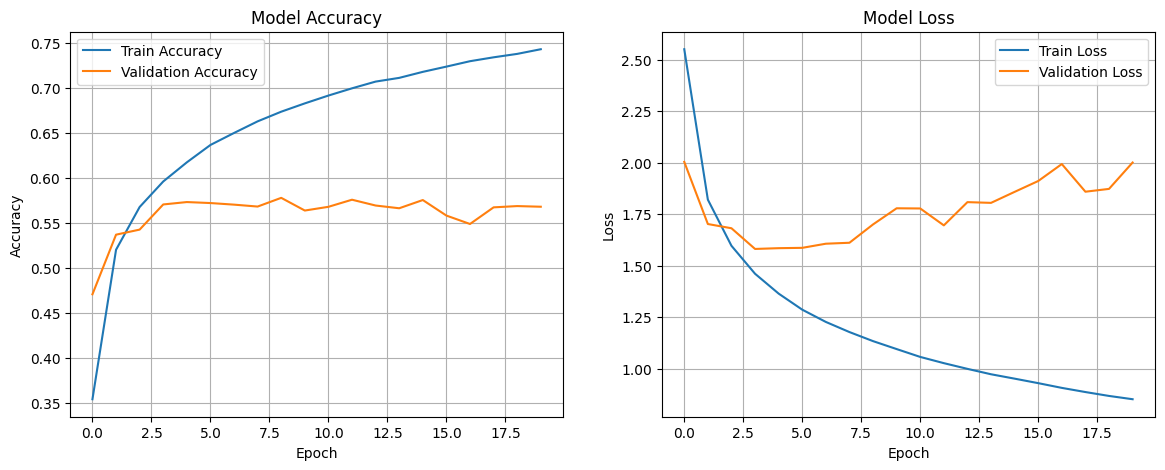

In [21]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

plt.show()

In [22]:
best_model = tf.keras.models.load_model('TxtClassification.keras')
# Evaluate the model on the test data
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

1310/1310 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - accuracy: 0.5704 - loss: 1.5848
Test Loss: 1.5813
Test Accuracy: 0.5704


In [23]:
# Sample new articles for prediction (make sure they are preprocessed)
new_articles = ["For me, learning is a series of small steps. Each one, a fragment of the whole."]
cleaned_new_articles = [clean_text(article) for article in new_articles]  # Clean the text

# Tokenize and pad the new articles
new_sequences = tokenizer.texts_to_sequences(cleaned_new_articles)
new_padded_sequences = pad_sequences(new_sequences, maxlen=max_length, padding='post')

# Make predictions
predictions = model.predict(new_padded_sequences)

# Get predicted class labels
predicted_classes = label_encoder.inverse_transform(predictions.argmax(axis=1))

# Display predictions
for article, category in zip(new_articles, predicted_classes):
    print(f"Article: {article}\nPredicted Category: {category}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Article: For me, learning is a series of small steps. Each one, a fragment of the whole.
Predicted Category: QUEER VOICES

